# DIABETIC RETINOPATHY - LOCAL TRAINED CNN - IT'S RANDOMLY GUESSING
malattia degli occhi che può occorrere ai diabetici. scopo dello studio è riuscire a allenare una rete che riconosca gli occhi malati o sani con una certa confidenza

# Load Data from disk
andiamo a caricare il nostro set di dati (immagini) di occhi diabetici

*Importo librerie utili*

In [1]:
%pylab inline
import pandas as pd
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


*Le immagini sono gia su disco, conto il numero totale di immagini nel dataset*

In [2]:
from os import listdir #This module provides a portable way of using operating system dependent functionality


path = "/home/gdeandrea/Scrivania/Diabete/DatiCurati/retinopathy-dataset"
train_dir = path + '/train_set'
validation_dir = path + '/validation_set'

num_sympt_train = len(listdir(train_dir + '/symptoms/'))
num_nosympt_train = len(listdir(train_dir + '/nosymptoms/'))
num_sympt_validation = len(listdir(validation_dir + '/symptoms/'))
num_nosympt_validation = len(listdir(validation_dir + '/nosymptoms/'))

print('N° casi totali: ', num_sympt_train + num_sympt_validation + num_nosympt_train + num_nosympt_validation)
print('N° casi sintomatici: ', num_sympt_train + num_sympt_validation)
print('N° casi asintomatici: ', num_nosympt_train + num_nosympt_validation)
print('----')
print('N° casi training: ', num_nosympt_train + num_sympt_train)
print('N° casi sintomatici training: ', num_sympt_train)
print('N° casi asintomatici training: ', num_nosympt_train)
print('----')
print('N° casi validation: ', num_nosympt_validation + num_sympt_validation)
print('N° casi sintomatici validation: ', num_sympt_validation)
print('N° casi asintomatici validation: ', num_nosympt_validation)

N° casi totali:  2063
N° casi sintomatici:  595
N° casi asintomatici:  1468
----
N° casi training:  1650
N° casi sintomatici training:  476
N° casi asintomatici training:  1174
----
N° casi validation:  413
N° casi sintomatici validation:  119
N° casi asintomatici validation:  294


*Creo generatori che riscalano i miei dati*

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#ImageDataGenerator()
#ImageDataGenerator().flow_from_directory()
train_image_generator = ImageDataGenerator(rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

*Uso methodo che carica le immagini e ci applica le trasformazioni che ho impostato con ImageDataGenerator()*

In [4]:
batch_size = 32
IMG_HEIGHT = 64
IMG_WIDTH = 64
#channels = 1 #Per b/w
channels = 3 #Per rgb

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    #shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    #color_mode='grayscale', #Per b/w
    class_mode='binary')
                                                           

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    #color_mode='grayscale', #Per b/w
    shuffle=False,
    class_mode='binary')
                                                              

#nel caso avessi avuto i dati non divisi, avrei potuto evitare la divisione in train e validation con ImageDataGenerator(validation_split = 0.2) 

Found 1650 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


*Guardo il tipo di dati in uscita e con funzione **next** ne prendo (batch_size) con relative labels come esempio*


*Verifico che siano effettivamente immagini 222x222 con 3 canali colore (RGB)*



*Plotto poi gli esempi*

In [5]:
print(train_data_gen)
sample_training_images, sample_training_labels = next(train_data_gen) #next prende (batch_size) elementi dell'iteratore train_data_gen (immagini -> s_tr_imgs) con relative labels (s_tr_lbls)

In [6]:
sample_training_images.shape

(32, 64, 64, 3)

In [7]:
sample_validation_images, sample_validation_labels = next(val_data_gen)

In [8]:
sample_validation_images.shape

(32, 64, 64, 3)

In [9]:
amax(sample_validation_images)

1.0

In [10]:
mean(sample_training_labels)

0.1875

In [11]:
type(sample_training_images)

numpy.ndarray

In [12]:
batch_size

32

## ----Routine B/W----

In [14]:
sample_training_imagez = []

for i in range(batch_size):
    sample_training_imagez.append(reshape(sample_training_images[i],(IMG_HEIGHT,IMG_WIDTH)))

ValueError: cannot reshape array of size 37632 into shape (112,112)

In [ ]:
example = array(sample_training_imagez)

In [ ]:
example.shape

## ----End Routine B/W----

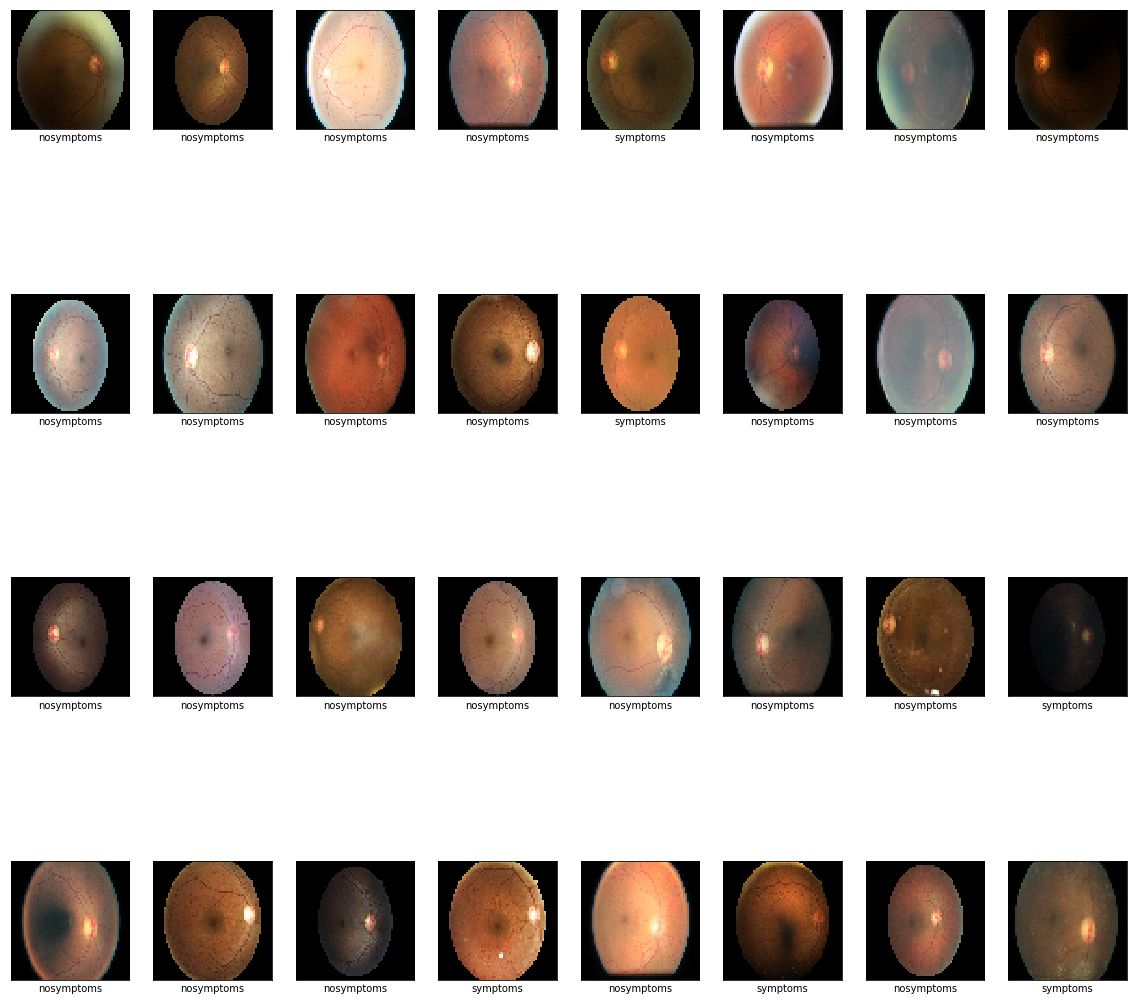

In [13]:
sample_training_values = []
sample_training_values.append('nosymptoms')
sample_training_values.append('symptoms')

plt.figure(figsize=(20,20))
for i in range(batch_size):
    plt.subplot(4,batch_size/4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(example[i], cmap=plt.cm.gray) #Per modalità b/w
    plt.imshow(sample_training_images[i], cmap=plt.cm.binary) #Per modalità RGB
    plt.xlabel(sample_training_values[int(sample_training_labels[i])])
plt.show()


# Data Augmentation
*Noto che le foto sono tra loro molto diverse per esposizione, colore, zoom etc. Per prevenire overfitting e "normalizzare" i dati andremo a creare duplicati delle immagini di **train** applicando trasformazioni di zoom, colore, esposizione etc. Le immagini di validation sono già pronte*

*Mantengo comunque due data set separati in modo da analizzare poi le differenze di performance*

*Genero il nuovo trasformatore*

In [14]:
#ImageDataGenerator()


aug_train_image_generator = ImageDataGenerator(
    #brightness_range = (0.5,1.5), #1 è no brightness change
    #width_shift_range = 0.3,
    #height_shift_range = 0.3,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #samplewise_center=True,
    #samplewise_std_normalization=True,
    zoom_range = 0.2,
    horizontal_flip=True,
    rescale = 1./255)

#aug_train_image_generator.fit(sample_training_images) #se uso featurewise_center/std

*Trasformo le immagini*

In [15]:
aug_train_data_gen = aug_train_image_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    #shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    #color_mode='grayscale', #Per b/w
    class_mode='binary')
    

Found 1650 images belonging to 2 classes.


*Creo un batch da (batch_size) esempi e le plotto*

In [16]:
print(aug_train_data_gen)
aug_sample_training_images, aug_sample_training_labels = next(aug_train_data_gen) #next prende (batch_size) elementi dell'iteratore train_data_gen (immagini -> s_tr_imgs) con relative labels (s_tr_lbls)
aug_sample_training_images.shape

(32, 64, 64, 3)

In [17]:
mean(aug_sample_training_labels)

0.28125

## ----Routine B/W----

In [19]:
aug_sample_training_imagez = []

for i in range(batch_size):
    aug_sample_training_imagez.append(reshape(aug_sample_training_images[i],(IMG_HEIGHT,IMG_WIDTH)))

ValueError: cannot reshape array of size 12288 into shape (64,64)

In [ ]:
aug_example = array(aug_sample_training_imagez)

In [ ]:
aug_example.shape

## ----End Routine B/W----

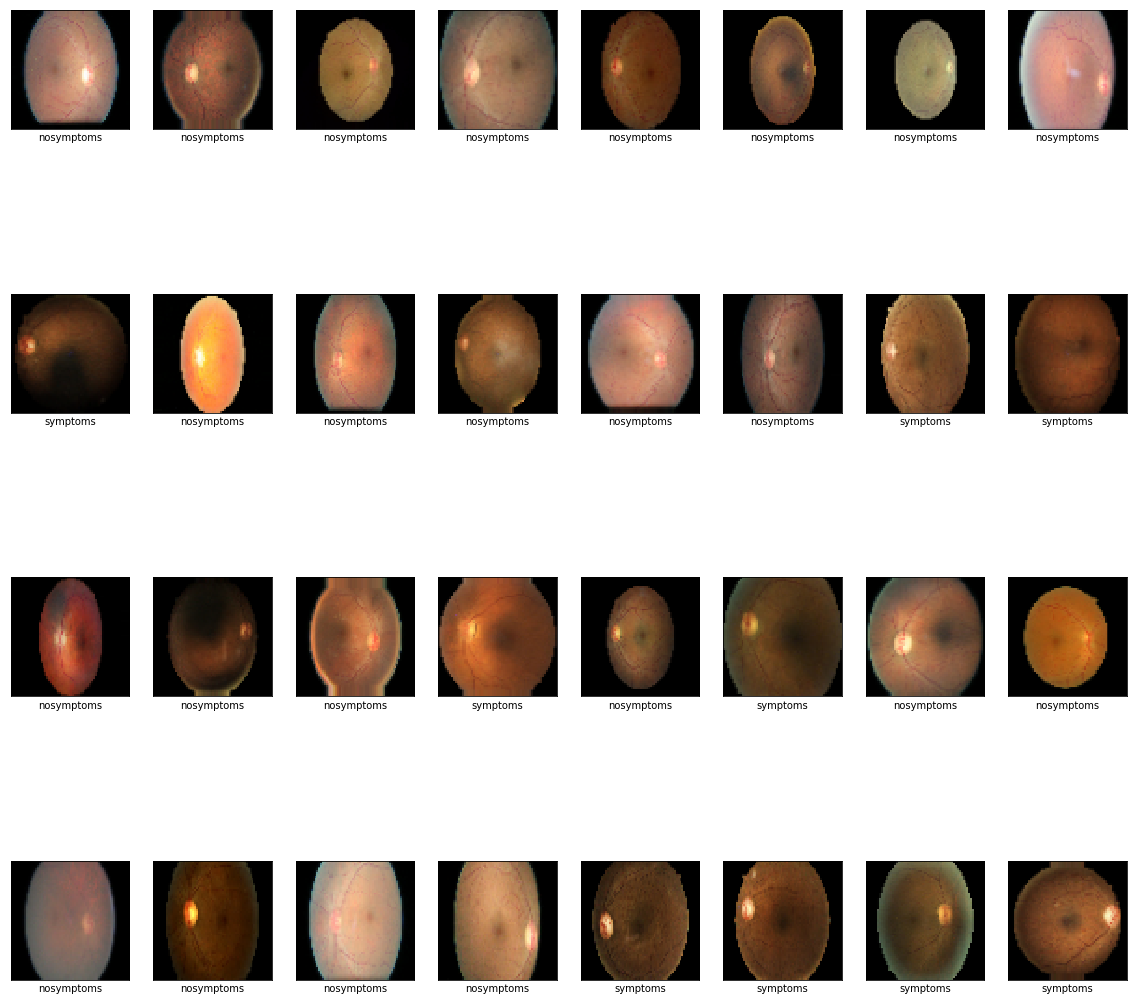

In [18]:
plt.figure(figsize=(20,20))
for i in range(batch_size):
    plt.subplot(4,batch_size/4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(aug_example[i], cmap=plt.cm.gray) #cmap=plt.cm.binary
    plt.imshow(aug_sample_training_images[i], cmap=plt.cm.binary) #Per modalità RGB

    plt.xlabel(sample_training_values[int(aug_sample_training_labels[i])])
plt.show()

# Building CNN

In [19]:
len(val_data_gen)

13

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

#Dropout è regolarizzazione
#Flatten trasforma in 1-d per Dense
#Conv2D processa i dati dell'immagine Conv2D(noutput,(altezza,larghezza),...)
#MaxPooling2D riduce l'output space di Conv2D
#GlobalAvgPool pure

*Definisco callback di early stopping*

In [40]:
E_S = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

*Definisco alcune quantità utili e il modello base*

In [44]:
n_classes = 1
sgd = SGD(lr=0.0001)
adam = Adam(lr=0.01)
tot_train = num_nosympt_train + num_sympt_train
tot_validation = num_nosympt_validation + num_sympt_validation
steps = ceil(tot_train / batch_size)
val_steps = ceil(tot_validation / batch_size)
epochs = 40

In [42]:
#Stack layers
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, channels), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Convolution2D(64, (3, 3), activation='relu'))
#model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dense(50, activation='relu'))
model.add(Dense(n_classes, activation='sigmoid'))

#Compile model
model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total para

## Test the model on non augmented data

In [45]:
#model.fit_generator()
# Fit the model
history = model.fit_generator(
    train_data_gen,
    epochs=epochs,
    steps_per_epoch=steps,
    #use_multiprocessing = True,
    #workers = 8,
    callbacks=[E_S], #EarlyStopping
    validation_data=val_data_gen,
    validation_steps=val_steps)
    



Epoch 1/40
52/52 [==============================] - 236s 5s/step - loss: 0.5891 - acc: 0.7006 - val_loss: 0.5101 - val_acc: 0.7119
Epoch 2/40
52/52 [==============================] - 204s 4s/step - loss: 0.5613 - acc: 0.7133 - val_loss: 0.5360 - val_acc: 0.7385
Epoch 3/40
52/52 [==============================] - 207s 4s/step - loss: 0.5562 - acc: 0.7170 - val_loss: 0.4983 - val_acc: 0.7119
Epoch 4/40
52/52 [==============================] - 202s 4s/step - loss: 0.5545 - acc: 0.7206 - val_loss: 0.5383 - val_acc: 0.7724
Epoch 5/40
52/52 [==============================] - 202s 4s/step - loss: 0.5586 - acc: 0.7145 - val_loss: 0.5260 - val_acc: 0.7119
Epoch 6/40
52/52 [==============================] - 199s 4s/step - loss: 0.5478 - acc: 0.7115 - val_loss: 0.4936 - val_acc: 0.7119
Epoch 7/40
52/52 [==============================] - 215s 4s/step - loss: 0.5563 - acc: 0.7079 - val_loss: 0.5521 - val_acc: 0.7724
Epoch 8/40
52/52 [==============================] - 214s 4s/step - loss: 0.5491 - a

*Plot the results*

In [29]:
history.history

{'loss': [0.6167430153760043,
  0.5656766998406613,
  0.5553090275417675,
  0.5597667965383241,
  0.5513565239761815,
  0.5565694463614261,
  0.5439781764420596,
  0.5410020567431595,
  0.5435583354487563,
  0.5445028135993264,
  0.5391102947610797,
  0.5451936296621959],
 'acc': [0.7042424,
  0.7115151,
  0.7151515,
  0.7266667,
  0.72121215,
  0.710303,
  0.72,
  0.7339394,
  0.7248485,
  0.7309091,
  0.7290909,
  0.7236364],
 'val_loss': [0.5586711684098611,
  0.5538118756734408,
  0.5062793286947104,
  0.4953941015096811,
  0.5156738712237432,
  0.5010314652552972,
  0.4759856668802408,
  0.5160420422370617,
  0.48181841235894424,
  0.4903360467690688,
  0.4793493552849843,
  0.5039211465762212],
 'val_acc': [0.7118644,
  0.7118644,
  0.73123485,
  0.7118644,
  0.75786924,
  0.7118644,
  0.78692496,
  0.72397095,
  0.75786924,
  0.7554479,
  0.7723971,
  0.7118644]}

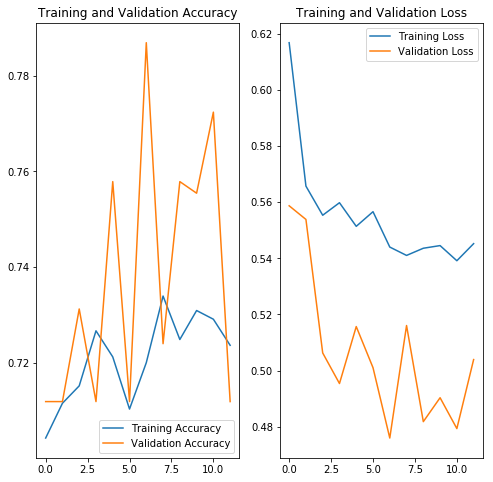

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


*I risultati non sono incoraggianti*

## Test model on augmented data

In [38]:
#Stack layers
model1 = Sequential()
model1.add(Convolution2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, channels), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2))) 
model1.add(Convolution2D(64, (3, 3), activation='relu'))
#model1.add(Dropout(0.2))
model1.add(GlobalAveragePooling2D())
#model1.add(MaxPooling2D(pool_size=(2, 2)))
#model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
#model1.add(Dense(50, activation='relu'))
model1.add(Dense(n_classes, activation='sigmoid'))

#Compile model
model1.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [39]:
aug_history = model1.fit_generator(
    aug_train_data_gen,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch,
    #callbacks=[E_S], #EarlyStopping
    epochs=epochs)

Epoch 1/15
52/52 [==============================] - 201s 4s/step - loss: 0.5815 - acc: 0.7115 - val_loss: 0.4965 - val_acc: 0.7119
Epoch 2/15
52/52 [==============================] - 167s 3s/step - loss: 0.5577 - acc: 0.7115 - val_loss: 0.5009 - val_acc: 0.7385
Epoch 3/15
52/52 [==============================] - 169s 3s/step - loss: 0.5575 - acc: 0.7230 - val_loss: 0.5040 - val_acc: 0.7119
Epoch 4/15
52/52 [==============================] - 169s 3s/step - loss: 0.5625 - acc: 0.7115 - val_loss: 0.5246 - val_acc: 0.7119
Epoch 5/15
52/52 [==============================] - 168s 3s/step - loss: 0.5573 - acc: 0.7170 - val_loss: 0.4932 - val_acc: 0.7627
Epoch 6/15
52/52 [==============================] - 167s 3s/step - loss: 0.5514 - acc: 0.7279 - val_loss: 0.5047 - val_acc: 0.7288
Epoch 7/15
52/52 [==============================] - 168s 3s/step - loss: 0.5547 - acc: 0.7279 - val_loss: 0.5041 - val_acc: 0.7772
Epoch 8/15
52/52 [==============================] - 167s 3s/step - loss: 0.5440 - a

*Plotto i dati*

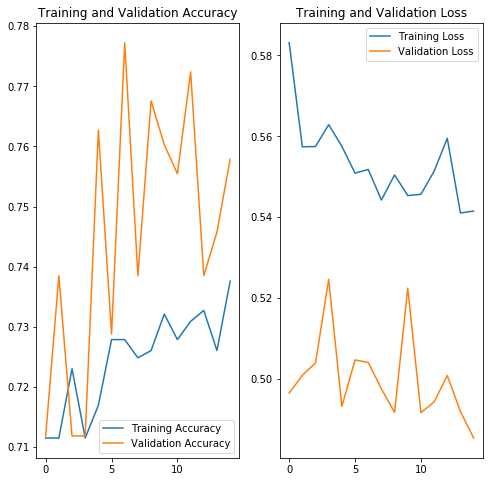

In [40]:
acc = aug_history.history['acc']
val_acc = aug_history.history['val_acc']

loss=aug_history.history['loss']
val_loss=aug_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Dovrei sicuramente provare ad allungare le epochs per vedere se effettivamente il trend apparentemente ascendente per acc e val_acc si conferma*